In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
%matplotlib inline
from IPython.display import display
plt.rc('font', family='Verdana')

from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# загружаем и разбиваем данные
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# вычисляем минимум и максимум по обучающим данным
scaler = MinMaxScaler().fit(X_train)

## Цепочки и конвейеры

In [2]:
# масштабируем обучающие данные
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# строим SVM на масштабированных обучающих данных
svm.fit(X_train_scaled, y_train)
# масштабируем тестовые данные и оцениваем качество на масштабированных данных
X_test_scaled = scaler.transform(X_test)
print("Правильность на тестовом наборе: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Правильность на тестовом наборе: 0.95


### Отбор параметров с помощью предварительной обработки

In [3]:
from sklearn.model_selection import GridSearchCV
# только в иллюстративных целях, не используйте этот код!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Наил знач правильности перекр проверки: {:.2f}".format(grid.best_score_))
print("Наил знач правильности на тесте: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("Наил параметры: ", grid.best_params_)

Наил знач правильности перекр проверки: 0.98
Наил знач правильности на тесте: 0.97
Наил параметры:  {'C': 1, 'gamma': 1}


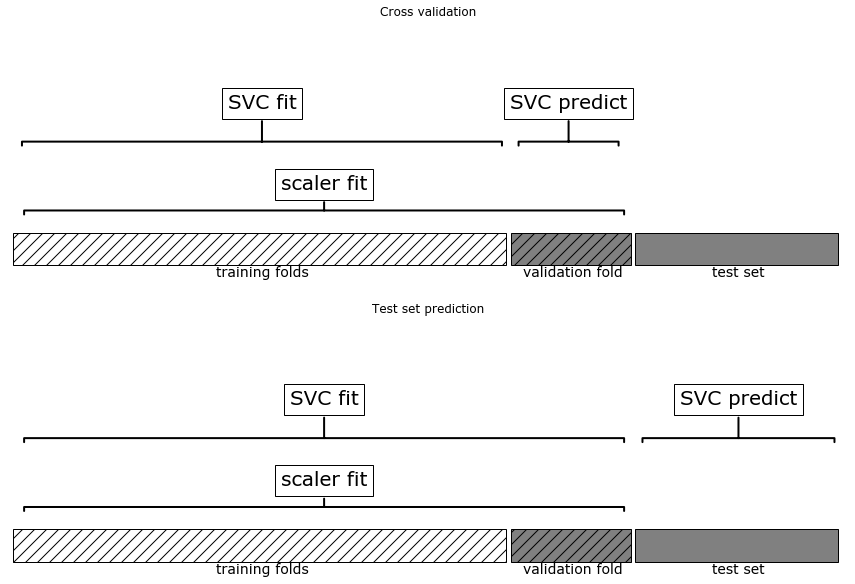

In [4]:
mglearn.plots.plot_improper_processing()

### Построение конвейеров

In [5]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [6]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [7]:
print("Правильность на тестовом наборе: {:.2f}".format(pipe.score(X_test, y_test)))

Правильность на тестовом наборе: 0.95


### Использование конвейера, помещенного в объект GridSearchCV

In [8]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [9]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Наил значение правильности перекр проверки: {:.2f}".format(grid.best_score_))
print("Правильность на тестовом наборе: {:.2f}".format(grid.score(X_test, y_test)))
print("Наилучшие параметры: {}".format(grid.best_params_))

Наил значение правильности перекр проверки: 0.98
Правильность на тестовом наборе: 0.97
Наилучшие параметры: {'svm__C': 1, 'svm__gamma': 1}


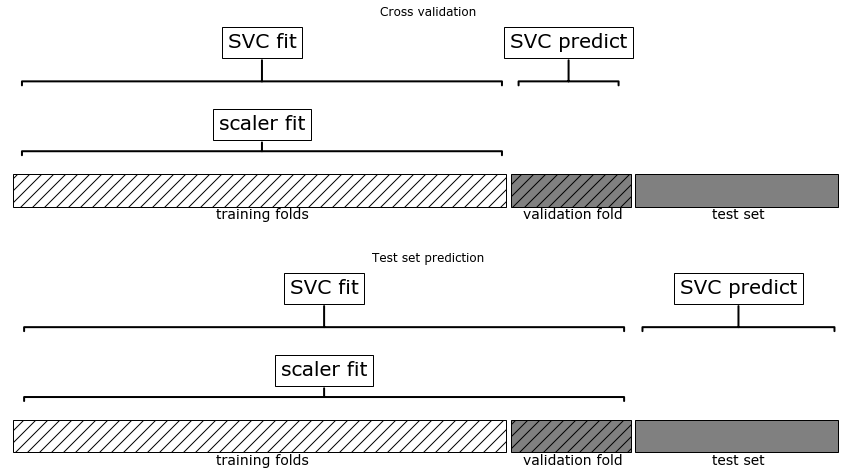

In [10]:
mglearn.plots.plot_proper_processing()

In [11]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [12]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("форма массива X_selected: {}".format(X_selected.shape))

форма массива X_selected: (100, 500)


In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("R-квадрат перекр проверки (cv только для ridge): {:.2f}".format(
      np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

R-квадрат перекр проверки (cv только для ridge): 0.91


In [14]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression,
                                             percentile=5)),
                 ("ridge", Ridge())])
print("R-квадрат перекр проверки (конвейер): {:.2f}".format(
np.mean(cross_val_score(pipe, X, y, cv=5))))

R-квадрат перекр проверки (конвейер): -0.25


### Общий интерфейс конвейера

In [15]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # перебираем все этапы, кроме последнего
        # подгоняем и преобразуем данные
        X_transformed = estimator.fit_transform(X_transformed, y)
    # осуществляем подгонку на последнем этапе
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [16]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # перебираем все этапы, кроме последнего
        # преобразуем данные
        X_transformed = step[1].transform(X_transformed)
    # получаем прогнозы на последнем этапе
    return self.steps[-1][1].predict(X_transformed)

![pipeline_illustration](images/pipeline.png)

### Удобный способ построения конвейеров с помощью функции ``make_pipeline``

In [17]:
from sklearn.pipeline import make_pipeline
# стандартный синтаксис
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# сокращенный синтаксис
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [18]:
print("Этапы конвейера:\n{}".format(pipe_short.steps))

Этапы конвейера:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Этапы конвейера:\n{}".format(pipe.steps))

Этапы конвейера:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


#### Работа с атрибутами этапов

In [20]:
# подгоняем заранее заданный конвейер к набору данных cancer
pipe.fit(cancer.data)
# извлекаем первые две главные компоненты на этапе "pca"
components = pipe.named_steps["pca"].components_
print("форма components: {}".format(components.shape))

форма components: (2, 30)


#### Работа с атрибутами конвейера, помещенного в объект GridSearchCV

In [21]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [22]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
print("Лучшая модель:\n{}".format(grid.best_estimator_))

Лучшая модель:
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


In [25]:
print("Этап логистической регрессии:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"]))

Этап логистической регрессии:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [26]:
print("Коэффициенты логистической регрессии:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"].coef_))

Коэффициенты логистической регрессии:
[[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


### Находим оптимальные параметры этапов конвейера с помощью решетчатого поиска

In [27]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

In [28]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [29]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

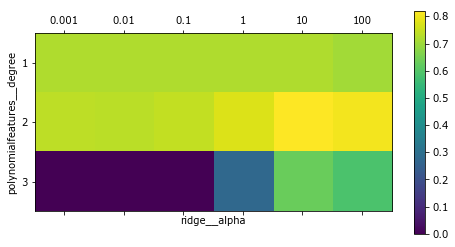

In [30]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
            vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
           param_grid['polynomialfeatures__degree'])

plt.colorbar()

In [31]:
print("Наилучшие параметры: {}".format(grid.best_params_))

Наилучшие параметры: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [32]:
print("R-квадрат на тестовом наборе: {:.2f}".format(grid.score(X_test, y_test)))

R-квадрат на тестовом наборе: 0.77


In [33]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("R-квадрат без полином. преобразования: {:.2f}".format(grid.score(X_test, y_test)))

R-квадрат без полином. преобразования: 0.63


In [34]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [35]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Наилучшие параметры:\n{}\n".format(grid.best_params_))
print("Наил значение правильности перекр проверки: {:.2f}".format(grid.best_score_))
print("Правильность на тестовом наборе: {:.2f}".format(grid.score(X_test, y_test)))

Наилучшие параметры:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Наил значение правильности перекр проверки: 0.99
Правильность на тестовом наборе: 0.98


### Выводы и перспективы